# AP Search

This notebook takes in a sample of waveforms and outputs a trained AP model. The training dataset should contain waveforms that are baseline-subtracted and normalized by their minimum or maximum value (whichever is greatest). Since AP is memory-intensive, the training dataset must contain < 10,000 waveforms.

In [1]:
# Load modules

import pickle, time, math, json
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances

# Set defaults for figures

%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='bright')
plt.style.use('../clint.mpl')


# Load data dict

with open('../data/p03_r003_train_data.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)

Before running AP, have to compute the pairwise distances between waveforms. We store these distances in the ```similarities``` matrix. This calculation should take about 1 minute. 

In [2]:
#Precompute similarity matrix 

wfs_norm = data_dict['wf_norm']

start_time = time.time()
similarities = -pairwise_distances(wfs_norm, metric='l1', n_jobs=-1)
print("--- %s minutes elapsed for similarities---" % ((time.time() - start_time)/60))

median = np.median(similarities)
minimum = np.amin(similarities)
      
print('Median = ', median)
print('Min = ', minimum)

--- 0.431660528977712 minutes elapsed for similarities---
Median =  -2871.0703
Min =  -10774.333


# Hyperparameter Optimization

Now that we have the similarities matrix, we have to find the hyperparameters that give us (roughly) the desired number of clusters (also called exemplars). For this, we use a grid search over two parameters of AP: the preference and the damping factor. If using more than 10 grid points in total, we suggest using an exclusive CPU node or submit a large memory node job. First, we define a function that runs AP on a given set of parameters and returns the number of exemplars found. 

In [3]:
def ap_search(pref, damp, verbose=True):  
    
    start_time = time.time()
    ap = AffinityPropagation(max_iter=500,
                             convergence_iter=25, 
                             verbose=verbose,
                             random_state=0,
                             preference = pref,
                             damping= damp,
                             affinity='precomputed').fit(X=similarities)
    
    n_exemps = len(ap.cluster_centers_indices_)
    elapsed_time = (time.time() - start_time)/60
    
    if verbose == True:
        print("--- %s minutes elapsed for AP iteration---" % (elapsed_time))
    
    return n_exemps

We now define the grid of parameter values and run AP for every grid point with multiprocessing. This should take between 5-10 minutes.

In [4]:
n_prefs = 5
n_damps = 2

preferences = np.linspace(minimum, -100, n_prefs)
dampings = np.linspace(0.925, 0.975, n_damps)

grid = [(x,y) for x in preferences for y in dampings]
start_time = time.time()
with mp.Pool(processes = n_prefs*n_damps) as p:
        result = np.array(p.starmap(ap_search, grid))
print("--- Elapsed time: %s minutes ---" % ((time.time() - start_time)/60))

Converged after 46 iterations.
--- 1.0135282675425212 minutes elapsed for AP iteration---
Converged after 46 iterations.
--- 1.1453500668207803 minutes elapsed for AP iteration---
Converged after 48 iterations.
--- 1.4019272287686666 minutes elapsed for AP iteration---
Converged after 137 iterations.
--- 2.016654205322266 minutes elapsed for AP iteration---
Converged after 128 iterations.
--- 2.4151397148768106 minutes elapsed for AP iteration---
Converged after 146 iterations.
--- 2.6320894996325177 minutes elapsed for AP iteration---
Converged after 145 iterations.
--- 2.9438589175542194 minutes elapsed for AP iteration---
Converged after 131 iterations.
--- 3.0172772208849588 minutes elapsed for AP iteration---
Converged after 184 iterations.
--- 3.4161203304926553 minutes elapsed for AP iteration---
Converged after 225 iterations.
--- 4.24863616625468 minutes elapsed for AP iteration---
--- Elapsed time: 4.2532274206479395 minutes ---


Once we have the number of exemplars found for every set of parameters, we find the set that gives us the desired number of exemplars. Any number between 50-100 gives a good representation of the data.

In [9]:
target_exemps = 100
diffs = abs(result - target_exemps)
opt_hyperpars, opt_result = grid[np.argmin(diffs)], result[np.argmin(diffs)]

print("Preference = ", opt_hyperpars[0])
print("Damping = ", opt_hyperpars[1])
print("Exemplars = ", opt_result)

Preference =  -5437.16630569109
Damping =  0.925
Exemplars =  102


# Training AP

We now train an AP model with the optimal set of hyperparameters. This should take less than 10 minutes.

In [10]:
start_time = time.time()
ap_opt = AffinityPropagation(max_iter=500,
                         convergence_iter=25, 
                         verbose=True,
                         random_state=0,
                         preference = opt_hyperpars[0],
                         damping= opt_hyperpars[1],
                         affinity='precomputed').fit(X=similarities)
print("--- Elapsed time: %s minutes ---" % ((time.time() - start_time)/60))

Converged after 150 iterations.
--- Elapsed time: 2.204467296600342 minutes ---


Here we plot all of the waveforms corresponding to the cluster centers (exemplars). If we find that the exemplars don't encompass all of the events expected in the dataset, we should increase the target number of exemplars and re-train AP with the updated set of parameters.

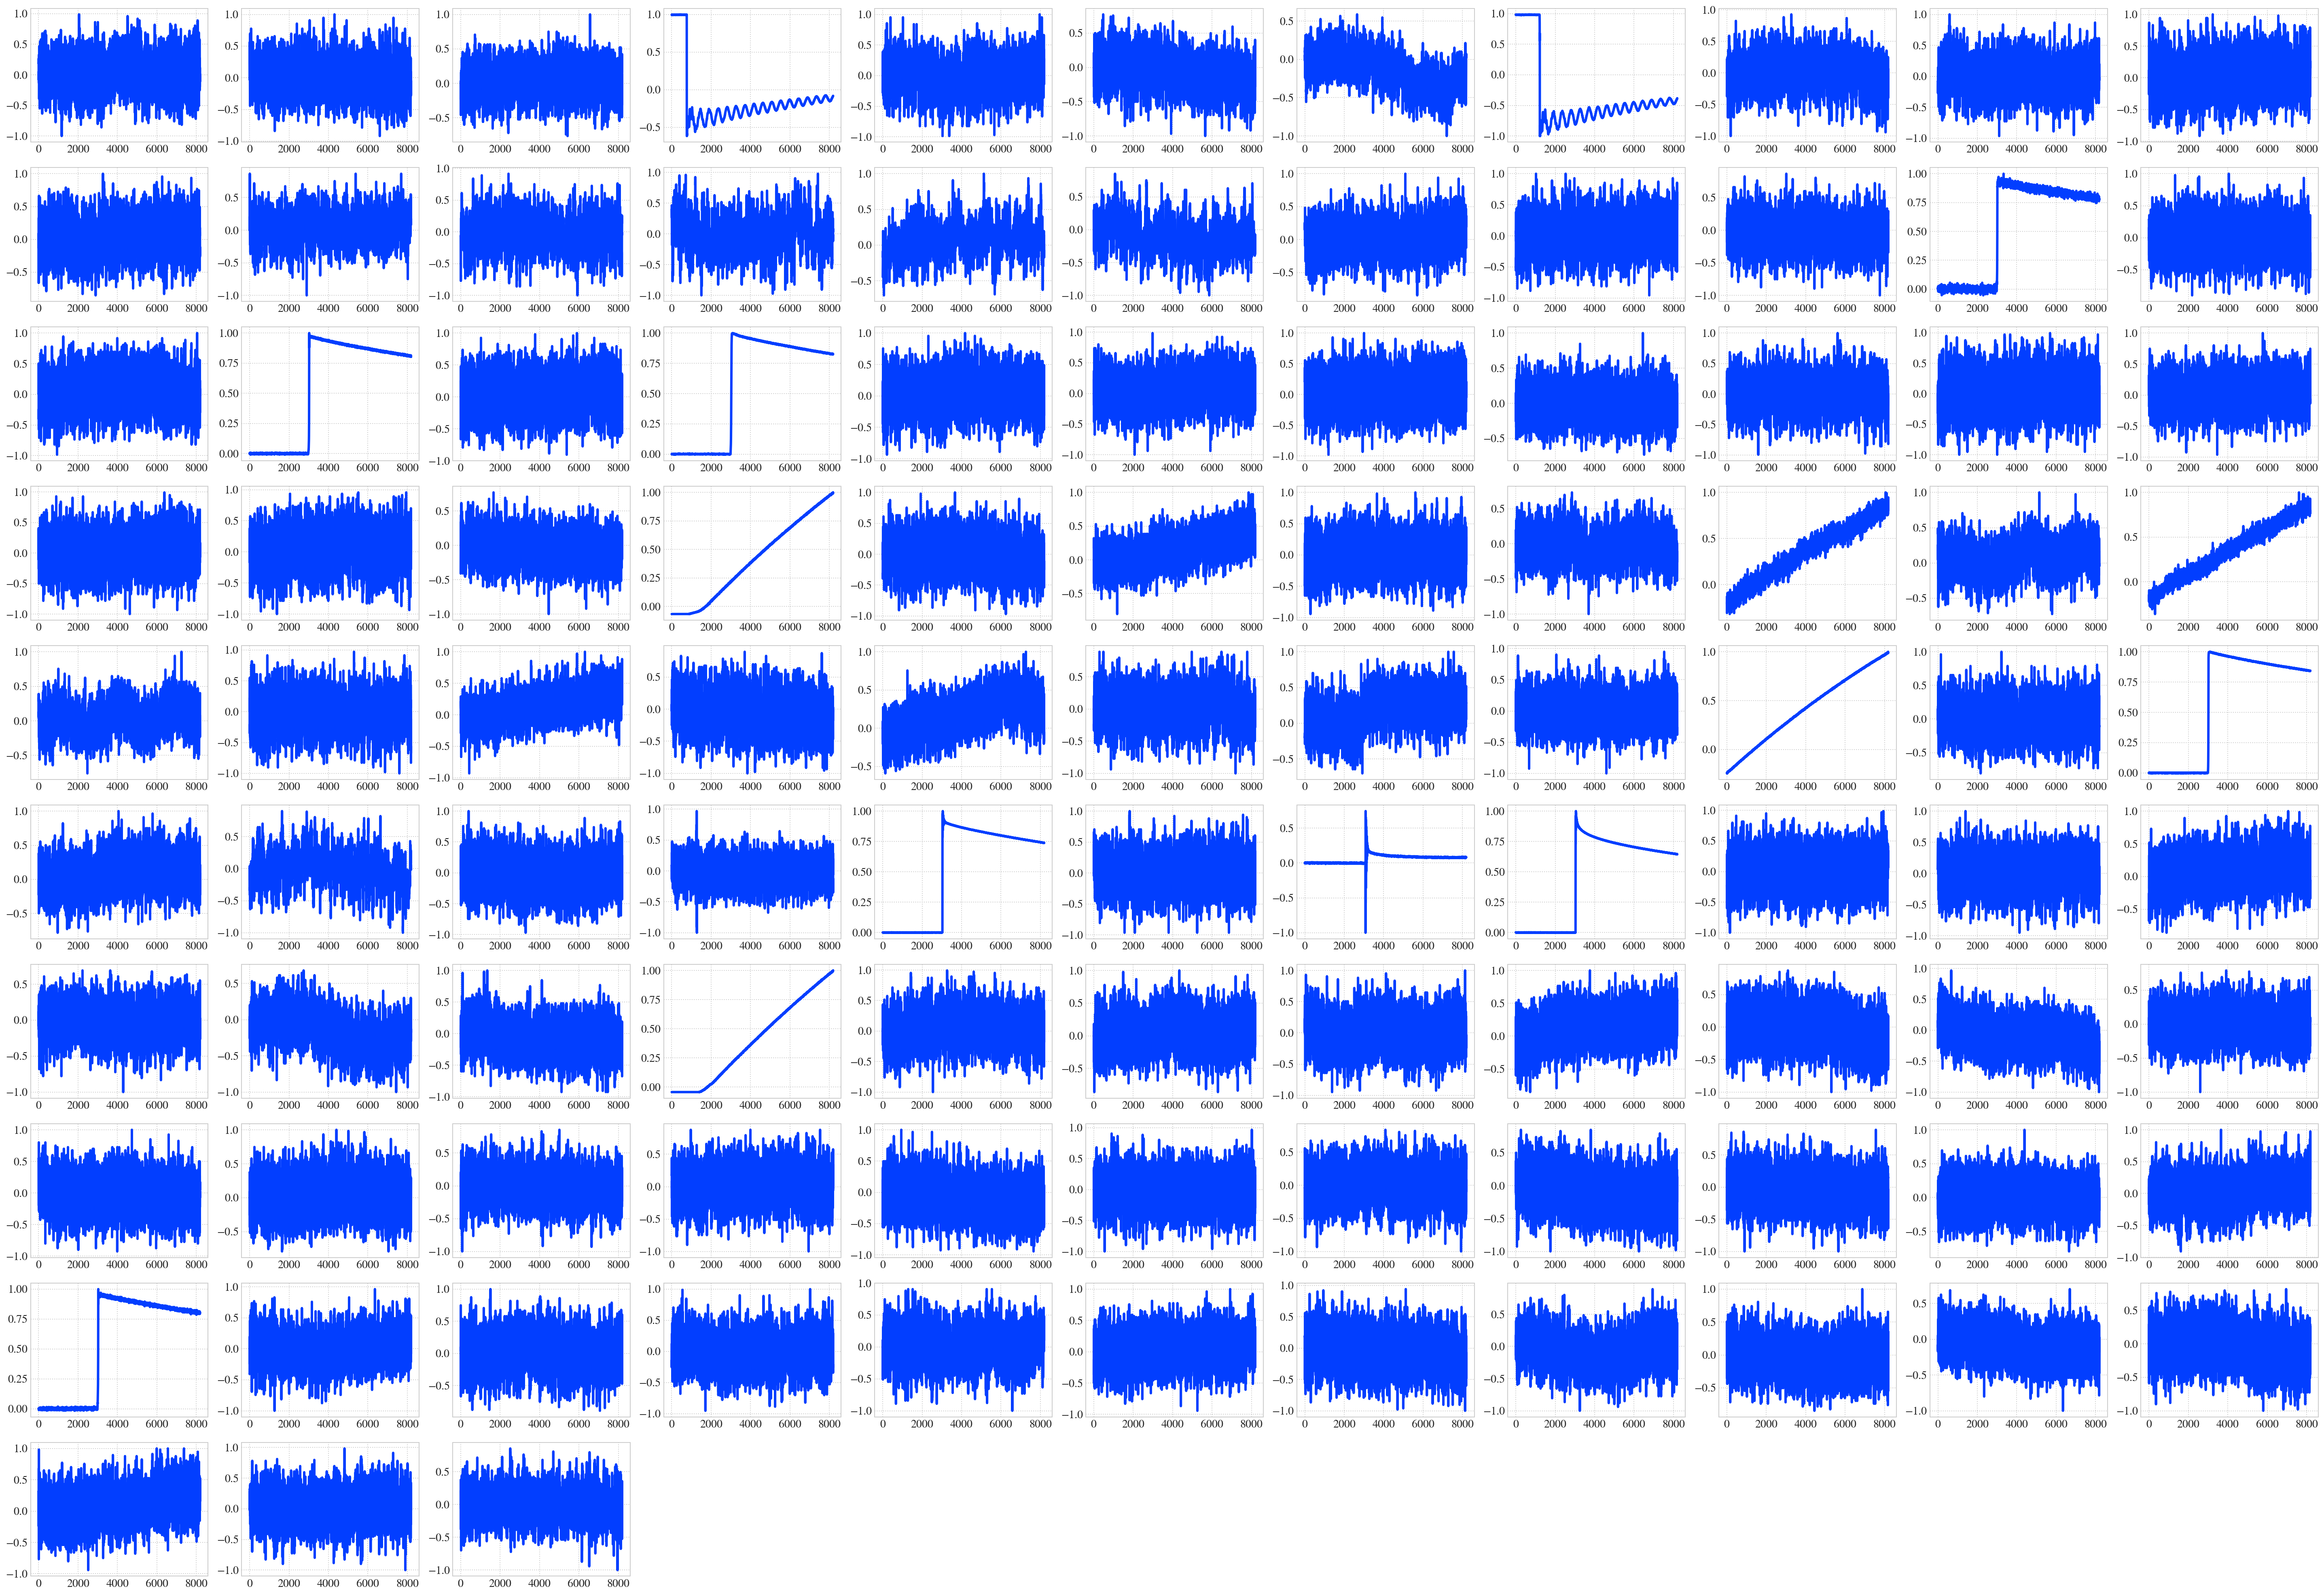

In [11]:
n_exemps_opt = len(ap_opt.cluster_centers_indices_)

%matplotlib inline
plt.figure(figsize=(40,30))
for j in range(n_exemps_opt):
    plt.subplot(math.ceil((n_exemps_opt)**0.5),math.ceil((n_exemps_opt)**0.5),j+1)
    idx = ap_opt.cluster_centers_indices_[j] 
    wf = wfs_norm[idx]
    plt.plot(wf, linestyle="-")

Lastly, we save the optimal hyperparameters in a json config file. This is mostly for documentation purposes and for hyperparameter stability studies. We also save the trained AP model as a binary file using pickle. 

In [19]:
with open('../data/hyperparameters.json', 'rb') as infile:
    hyperparams_dict = json.load(infile)
    
hyperparams_dict['AP']['median'] = median
hyperparams_dict['AP']['minimum'] = minimum
hyperparams_dict['AP']['damping'] = opt_hyperpars[1]
hyperparams_dict['AP']['preference'] = opt_hyperpars[0]
hyperparams_dict['AP']['exemplars'] = n_exemps_opt

In [20]:
with open("../data/hyperparameters.json", "w") as outfile:
    json.dump(hyperparams_dict, outfile)

In [18]:
with open("../data/ap.sav", "wb") as ap_file:
    pickle.dump(ap_opt, ap_file)